<a href="https://colab.research.google.com/github/otanet/Recognizing_Textual_Entailment/blob/main/%E8%87%AA%E7%84%B6%E8%A8%80%E8%AA%9E%E5%87%A6%E7%90%86BERT%E3%83%A2%E3%83%87%E3%83%AB%E3%81%A7%E3%81%AE%E6%8E%A8%E8%AB%96%E8%AA%8D%E8%AD%98%E3%81%A8%E7%9B%B8%E6%80%A7%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **自然言語処理BERTモデルでの推論認識と相性分析**

YouTubeに内容説明の動画：https://youtu.be/dyipetTsZ40

---


RTE(Recognizing Textual Entailment)推論認識の説明

RTEとはある前提文と仮説文、二つを与え、前提文から仮説が推論されればYES,そうでなければNOとする判定をシステムで行うタスクです。


例えば

前提の情報は：  　　　　 人身事故で電車が遅れた。　　

仮説：　　　　　　　  　乗客に影響が出た。

NLPモデル判定：　　　　 YES


---


推論認識は、質問応答や情報検索など、テキスト情報の内容の理解が必要なタスクにおいて重要です。


In [ ]:
!pip install transformers
!pip install mecab-python3

In [ ]:
import pandas as pd
import xml.etree.ElementTree as ET
import os
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertForSequenceClassification,AdamW,BertConfig
import time
import datetime

In [ ]:
if torch.cuda.is_available():       
  
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('daigo/bert-base-japanese-sentiment')

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils.py:831: FutureWarning: Parameter max_len is deprecated and will be removed in a future release. Use model_max_length instead.
  category=FutureWarning,


##  **Tokenizetionとモデルのインプットについて、、、**



推論認識はインプットが二つ（前提文情報、仮説文）、あとアウトプットが一つ（判定）です。

<img src="https://drive.google.com/uc?export=view&id=1OX3rPNT2FBWTztbHET9vNuh-KUcsrB9U" width = 50%>


また、モデルの形が二つインプットによって、様様なビジネスに応用することができます。

例えば：


*   二つ事象の相性認識
*   物と人の関係認識



---



>**商品とユーザーは、相性認識の例：**


>あるお店
* 自己PRでの特徴：
  * 濃厚煮干スープが絶品！ 厳選した煮干・魚介と濃厚豚骨スープを合わせた「濃厚煮干中華そば」。

>SNSネット上（Facebook, Twitter, Line）にあるコメントのフォロー者
* あるコメント：
  * 濃くのあるスープで、めちゃくちゃ美味いっ！！豚肉、穂先メンマも相変わらず抜群の美味さ。



>ある店とあるユーザーの相性認識によって、人工知能システムでユーザーに相性順で推薦する

*また、事象と人の相性認識は広告業、仲介業など多くビジネスに利用することができます。*

In [ ]:
encoded_data = tokenizer.encode_plus(
    '濃厚煮干スープが絶品！ 厳選した煮干・魚介と濃厚豚骨スープを合わせた「濃厚煮干中華そば」。',
    text_pair='濃くのあるスープで、めちゃくちゃ美味いっ！！豚肉、穂先メンマも相変わらず抜群の美味さ。', 
    add_special_tokens=True)

In [ ]:
tokenizer.tokenize('濃厚煮干スープが絶品！ 厳選した煮干・魚介と濃厚豚骨スープを合わせた「濃厚煮干中華そば」。'),tokenizer.tokenize('濃くのあるスープで、めちゃくちゃ美味いっ！！豚肉、穂先メンマも相変わらず抜群の美味さ。')

(['濃厚', '煮', '##干', 'スープ', 'が', '絶', '##品', '!', '厳', '##選', 'し', 'た', '煮', '##干', '・', '魚介', 'と', '濃厚', '豚', '骨', 'スープ', 'を', '合わせ', 'た', '「', '濃厚', '煮', '##干', '中華', 'そば', '」', '。']

 ['濃', '##く', 'の', 'ある', 'スープ', 'で', '、', 'め', '##ちゃ', '##く', '##ちゃ', '美味', 'いっ', '!!', '豚肉', '、', '穂', '##先', 'メン', '##マ', 'も', '相', '##変', '##わら', '##ず', '抜群', 'の', '美味', 'さ', '。'])

In [ ]:
encoded_data

{'input_ids': [2, 24481, 9698, 29893, 14173, 14, 1814, 28728, 679, 2191, 28664, 15, 10, 9698, 29893, 35, 24035, 13, 24481, 10102, 2552, 14173, 11, 1943, 10, 36, 24481, 9698, 29893, 2725, 9313, 38, 8, 3, 3573, 28504, 5, 31, 14173, 12, 6, 2087, 7255, 28504, 7255, 18178, 1281, 3421, 26173, 6, 8174, 28947, 5470, 28523, 28, 423, 28801, 1747, 28700, 22947, 5, 18178, 26, 8, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

## **訓練のデータセットとデータ前処理**

訓練データーセット

[Textual Entailment 評価データ](http://nlp.ist.i.kyoto-u.ac.jp/edit.php?Textual%20Entailment%20%E8%A9%95%E4%BE%A1%E3%83%87%E3%83%BC%E3%82%BF)RTE(Recognizing Textual Entailment) -> 推論認識   

内容を説明：

* 有る文書の前提文で、有る仮説文は推論が成立かどうかを判定モデルです。　前提情報の文章が一つと仮説文が一つで、２つインプットがあり、結果は前提情報によって仮説の推論が成立かどうか判定する。つまり、アウトプットが一つで分類することです。


### **PyTorchのBERTモデルにインプットするため、データ前処理する。**

In [ ]:
def xml2df(xml_data):
    root = ET.XML(xml_data) # element tree
    all_records = []
    for i, child in enumerate(root):
        record = {}
        record['id'] = child.get('id')
        record['label'] = child.get('label')
        record['category'] = child.get('category')
        for subchild in child:
            record[subchild.tag] = subchild.text
        all_records.append(record)
    df = pd.DataFrame(all_records)
    return df

In [ ]:
import requests

URL = "http://nlp.ist.i.kyoto-u.ac.jp/nl-resource/rte/entail_evaluation_set_label_conv.xml"

response = requests.get(URL)

with open('feed.xml', 'wb') as file:
    file.write(response.content)

In [ ]:
text_xml = open('feed.xml').read()
df = xml2df(text_xml)

In [ ]:
# load XML to dataframe
#text_xml = open('Recognizing_Textual_Entailment_2.xml').read()
#df = xml2df(text_xml)

In [ ]:
df.head()

,id,label,category,t1,t2,label_num
0,0,N,語彙(体言):下位→上位,もみじ狩りに行った。,狩りをした。,0
1,1,N,語彙(体言):下位→上位,ジョンは怠慢で、ビルは勤勉だ。,犬は怠慢で、人は勤勉だ。,0
2,2,N,語彙(体言):下位→上位,羽田に行った。,千葉に行った。,0
3,3,N,語彙(体言):下位→上位,英文法を勉強した。,中国語を勉強した。,0
4,4,N,語彙(体言):下位→上位,角館はみちのくの小京都である。,角館は京都である。,0


In [ ]:
df.loc[df.label == 'N'].sample(5)[['label','t1','t2']]

,label,t1,t2
92,N,根菜を使った。,レンコンを食べた。
1224,N,せんべいがしけっていて、残念だった。,せんべいはがっかりした。
2064,N,松茸は人工栽培できないので、外国から輸入している。,日本人は松茸が好きだ。
1845,N,五羽の仔ウサギが産まれて、三羽が死んでしまった。,全部で8羽の仔ウサギがいる。
2428,N,壁のカレンダーに予定を書き込んでください。,机にカレンダーがある。


In [ ]:
df.loc[df.label == 'Y'].sample(5)[['label','t1','t2']]

,label,t1,t2
20,Y,チョコレート工場の見学に行った。,工場見学に行った。
2353,Y,権力と金と女が欲しい。,権力と金が欲しい。
1425,Y,パンにカビが生えていた。,パンは古かった。
2045,Y,太郎のおみやげは、ちんすこうだった。,太郎はお土産にちんすこうを買って来た。
499,Y,夫が風邪をひいた。,私は妻である。


In [ ]:
df.describe()

,id,label,category,t1,t2
count,2472,2472,2472,2472,2472
unique,2472,2,166,1295,2422
top,570,Y,語彙(用言):言い換え,どうも具合が悪い。,亜硫酸の生成方法を知らなかった。
freq,1,1586,250,7,4


In [ ]:
df['label_num'] = df['label'].map({'Y': 1, 'N': 0})

In [ ]:
df

,id,label,category,t1,t2,label_num
0,0,N,語彙(体言):下位→上位,もみじ狩りに行った。,狩りをした。,0
1,1,N,語彙(体言):下位→上位,ジョンは怠慢で、ビルは勤勉だ。,犬は怠慢で、人は勤勉だ。,0
2,2,N,語彙(体言):下位→上位,羽田に行った。,千葉に行った。,0
3,3,N,語彙(体言):下位→上位,英文法を勉強した。,中国語を勉強した。,0
4,4,N,語彙(体言):下位→上位,角館はみちのくの小京都である。,角館は京都である。,0
...,...,...,...,...,...,...
2467,2467,N,その他:名前,香と真樹が結婚した。,真樹は男性である。,0
2468,2468,Y,その他:命名,ラッシュにぶつかった。,犬にぶつかった。,1
2469,2469,Y,その他|語彙(体言):定義的,ボジョレ・ヌーヴォーが解禁になった。,ボジョレ・ヌーヴォーの販売には解禁日がある。,1
2470,2470,Y,その他|構文:主語の変換,彼は英語が堪能である。,彼の英語はうまい。,1


In [ ]:
df.loc[0]['t1']

'もみじ狩りに行った。'

In [ ]:
# Print the original sentence.
print(' Original: ', df.loc[0]['t1'])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(df.loc[0]['t1']))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(df.loc[0]['t1'])))

 Original:  もみじ狩りに行った。
Tokenized:  ['もみ', '##じ', '狩り', 'に', '行っ', 'た', '。']
Token IDs:  [23688, 28635, 11899, 7, 517, 10, 8]


In [ ]:
encoded_data = tokenizer.encode_plus('もみじ狩りに行った。',text_pair='狩りをした。', add_special_tokens=True)

In [ ]:
encoded_data

{'input_ids': [2, 23688, 28635, 11899, 7, 517, 10, 8, 3, 11899, 11, 15, 10, 8, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
inputs = []
labels = []
for index, row in df.iterrows():
    encoded_sent = tokenizer.encode_plus(row['t1'],text_pair=row['t2'], add_special_tokens=True)
    inputs.append(encoded_sent)
    labels.append(row['label_num'])

print('Token IDs:', inputs[10])
print('\n',labels[10])

Token IDs: {'input_ids': [2, 5250, 5, 73, 28614, 28528, 28764, 9, 6, 17172, 340, 28482, 205, 308, 10, 8, 3, 5250, 5, 73, 28614, 28528, 28764, 9, 6, 865, 28652, 308, 10, 8, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

 0


In [ ]:
len(inputs)

2472

In [ ]:
input_ids = []
token_type_ids = []
attention_masks = []

for x in inputs:
    input_ids.append(x["input_ids"])
    token_type_ids.append(x["token_type_ids"])
    attention_masks.append(x["attention_mask"])

In [ ]:
!ls

bert-output-vector.png	Recognizing_Textual_Entailment_2.xml
feed.xml		sample_data


#### データの補充と削除

![picture](https://drive.google.com/uc?export=view&id=1ZFBMH1ED9oBbYyfXcVp3Jq-cT9VgJGsB)

MAX LEN は50単語なので、64で設定すれば、問題がないと思います。

もしインプットの長さが512個単語を超えたら、削除します。（後ろ削除か、中間に削除かなど）

単語数が足りなくでも後ろ設定数までに0を補足します。

Padding & Truncating!

In [ ]:
max([len(sen) for sen in input_ids])

50

In [ ]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 64
#MAX_LEN = 50


print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

token_type_ids = pad_sequences(token_type_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

attention_masks = pad_sequences(attention_masks, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
print('\nDone.')


Padding/truncating all sentences to 64 values...

Padding token: "[PAD]", ID: 0

Done.


In [ ]:
input_ids[0],token_type_ids[0],attention_masks[0],labels[0]

(array([    2, 23688, 28635, 11899,     7,   517,    10,     8,     3,
        11899,    11,    15,    10,     8,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 0)

#### 訓練のデータセットを分割する。


データセットを分割して、90％が訓練用です。10％が検証用です。


In [ ]:
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the token_type.
train_token_type, validation_token_type, _, _ = train_test_split(token_type_ids, labels,
                                             random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                                       random_state=2018, test_size=0.1)

#### PyTorchのデータタイプに変換する

Torch tensorsにインプットデータを変換する。

In [ ]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_token_type = torch.tensor(train_token_type)
validation_token_type = torch.tensor(validation_token_type)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

Pytorch訓練データセットに生成する

Pytorch検証データセットに生成する

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32
#batch_size = 16


train_data = TensorDataset(train_inputs, train_token_type, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


validation_data = TensorDataset(validation_inputs, validation_token_type, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

## **Fine-Tuning the model** 

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "daigo/bert-base-japanese-sentiment",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,)

In [ ]:
# run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
model.get_input_embeddings()

Embedding(32000, 768, padding_idx=0)

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (32000, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
#epochs = 4
#epochs = 8
epochs = 10

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
train_dataloader

### ビジネスのタスクに新しいモデルの学習


transformersのドキュメントページ：
https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification

In [ ]:
import random

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # `batch` contains four pytorch tensors:
        #   [0]: input ids 
        #   [1]: train token type
        #   [2]: attention masks
        #   [3]: labels 
        b_input_ids = batch[0].to(device)
        b_train_token_type = batch[1].to(device)
        b_input_mask = batch[2].to(device)
        b_labels = batch[3].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=b_train_token_type, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]

        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_train_token_type, b_input_mask, b_labels = batch
        
        #print('data:',b_input_ids,'\n',b_train_token_type,'\n',b_input_mask)
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            outputs = model(b_input_ids, 
                            token_type_ids=b_train_token_type, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 10 ========
Training...
  Batch    40  of     70.    Elapsed: 0:00:08.

  Average training loss: 0.68
  Training epcoh took: 0:00:14

Running Validation...
  Accuracy: 0.65
  Validation took: 0:00:00

======== Epoch 2 / 10 ========
Training...
  Batch    40  of     70.    Elapsed: 0:00:08.

  Average training loss: 0.60
  Training epcoh took: 0:00:14

Running Validation...
  Accuracy: 0.65
  Validation took: 0:00:00

======== Epoch 3 / 10 ========
Training...
  Batch    40  of     70.    Elapsed: 0:00:08.

  Average training loss: 0.51
  Training epcoh took: 0:00:14

Running Validation...
  Accuracy: 0.67
  Validation took: 0:00:00

======== Epoch 4 / 10 ========
Training...
  Batch    40  of     70.    Elapsed: 0:00:08.

  Average training loss: 0.37
  Training epcoh took: 0:00:14

Running Validation...
  Accuracy: 0.64
  Validation took: 0:00:00

======== Epoch 5 / 10 ========
Training...
  Batch    40  of     70.    Elapsed: 0:00:08.

  Average training loss: 0.2

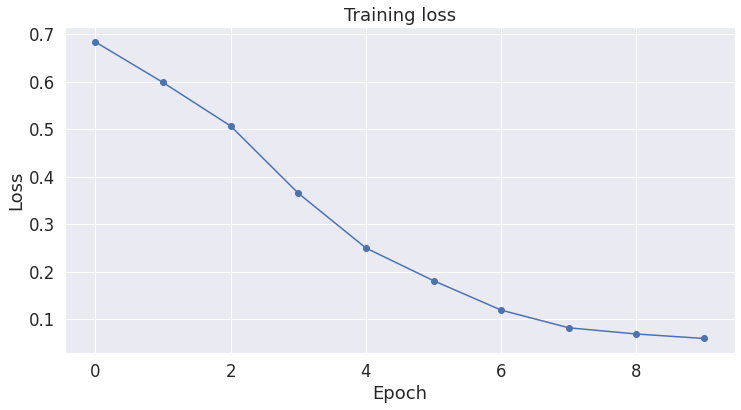

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## **モデルの性能を検証**


検証ファンクションを作成

In [ ]:
def rte_function(text,text2):

    t_inputs = tokenizer.encode_plus(text,text_pair=text2, add_special_tokens=True)
    
    t_input_ids = pad_sequences([t_inputs["input_ids"]], maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
    t_token_type_ids = pad_sequences([t_inputs["token_type_ids"]], maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
    t_attention_mask = pad_sequences([t_inputs["attention_mask"]], maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
    
    t_input_ids = torch.tensor(t_input_ids[0]).unsqueeze(0)
    t_token_type_ids = torch.tensor(t_token_type_ids[0]).unsqueeze(0)
    t_attention_mask = torch.tensor(t_attention_mask[0]).unsqueeze(0)

    t_input_ids = t_input_ids.to(device)
    t_token_type_ids = t_token_type_ids.to(device)
    t_attention_mask = t_attention_mask.to(device)
    
    with torch.no_grad():    
        outputs = model(t_input_ids, token_type_ids=t_token_type_ids, attention_mask=t_attention_mask)
    
    ng = outputs[0][0][0].item()
    ok = outputs[0][0][1].item()
    ng_p = np.exp(ng)/(np.exp(ng)+np.exp(ok))
    ok_p = np.exp(ok)/(np.exp(ng)+np.exp(ok))
    
    if ng_p>=ok_p:
        result = {"label" : "元の情報からの仮説は推測が成立しません。","score" : ng_p}
    else:
        result = {"label" : "元の情報からの仮説は推測が成立です。","score" : ok_p}
        
    return result

In [ ]:
# 情報源の文章
premise = '避難訓練があった。'
# 仮説
hypothesis = '災害時を想定している。'


# 仮説について、推論成立かどうか判定
rte_function(premise,hypothesis)

{'label': '元の情報からの仮説は推測が成立です。', 'score': 0.9972688753667335}

In [ ]:
# 情報源の文章
premise = '今日は浴衣姿の人が多い。'
# 仮説
hypothesis = '花火大会がある。'


# 仮説について、推論成立かどうか判定
rte_function(premise,hypothesis)

{'label': '元の情報からの仮説は推測が成立しません。', 'score': 0.9919223189238091}

In [ ]:
# 情報源の文章
premise = '太郎は次郎より背が高い。'
# 仮説
hypothesis = '次郎は太郎より背が低い。'


# 仮説について、推論成立かどうか判定
rte_function(premise,hypothesis)

{'label': '元の情報からの仮説は推測が成立です。', 'score': 0.9254253411265165}

## **訓練した自然言語モデルを保存する**





In [ ]:
import os

output_dir = './sa_model_save/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model 
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./sa_model_save/


('./sa_model_save/vocab.txt',
 './sa_model_save/special_tokens_map.json',
 './sa_model_save/added_tokens.json')

In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

ls: cannot access './model_save/pytorch_model.bin': No such file or directory


Colabノートブックを閉じる前に、訓練したのモデルをロカール或いはGoogle Driveにダンロードします。




In [ ]:
!cp -r ./model_save/ "./drive/a directory in your Google Drive/BERT Fine-Tuning/"

In [ ]:
model = model_class.from_pretrained(output_dir)
tokenizer = tokenizer_class.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)